# Исследование направлений расходов маркетингового отдела

## Задача, контекст

### Контекст исследования

Коллеги из маркетингового отдела стараются оптимизировать маркетинговые расходы, в связи с чем им понадобилась помощь с поиском убыточных источников трафика. 
В рамках исследования рассматривается промежуток времени с июня 2017 года по май 2018. На данные по посещениям, заказам и рекламе за указанный промежуток какого-либо внешнего влияния не должен оказать – запоминающихся социальных/экономических/политических событий не происходило. 

С другой стороны, с середины нулевых набирает популяронсть такое вид сервисов, как онлайн-кинотеатры по подписке. Данный фактор нужно учитывать при работе с данными.

### Постановка задачи

Коллеги попросили изучить:

- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.



## Выгрузка данных, подготовка к анализу

### Ознакомление с данными

Для начала импортируем необходимые библиотеки, а также создадим датафреймы.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math as mth
from IPython.display import display
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Создадим функцию для быстрого просмотра основной информации по датафрейму.

In [3]:
def brief(x):
    x.info()
    display(x.head(5))
    print('Количество дубликатов в датафрейме: {}'.format(x.duplicated().sum()))

Рассмотрим поочередно датафреймы.

<b> Посещения</b>

Датафрейм `visits` содержит следующие поля:

- `Uid` — уникальный идентификатор пользователя,
- `Device` — категория устройства пользователя,
- `Start Ts` — дата и время начала сессии,
- `End Ts` — дата и время окончания сессии,
- `Source Id` — идентификатор источника перехода на сайт.


In [4]:
brief(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Количество дубликатов в датафрейме: 0


Отметим несколько моментов по датафрейму

1. Пропусков по данным нет.
2. Единственные типы данных, которые необходимо преобразовать – даты в столбцах `End Ts` и `Start Ts`.

Посмотрим дополнительно на распределение по `Device`, а также по `Source Id`

In [5]:
print('Распределение по столбцу Device:')
print(visits['Device'].value_counts())
print('Распределение по столбцу Source Id:')
print(visits['Source Id'].value_counts())

Распределение по столбцу Device:
desktop    262567
touch       96833
Name: Device, dtype: int64
Распределение по столбцу Source Id:
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64


Из четырёх человек трое предпочитают заходить на сайт через ПК.

**Заказы**

В датафрейме следующие виды данных:

- `Uid` — уникальный идентификатор пользователя,
- `Buy Ts` — дата и время заказа,
- `Revenue` — сумма заказа.


In [6]:
brief(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Количество дубликатов в датафрейме: 0


Отметим, что в датафрейме нужно изменить тип даных для `Buy Ts`.

**Расходы**

- `source_id` — идентификатор рекламного источника,
- `dt` — дата проведения рекламной кампании,
- `costs` — расходы на эту кампанию.

In [7]:
brief(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Количество дубликатов в датафрейме: 0


Для датафрейма `costs` также нужно провести корректировку типа даты.

**Временной диапазон**

Далее уточним, соответствует ли временной диапазон в датафреймах заданному в исследовании.

In [8]:
print('Временной диапазон строк в датафрейме visits: с {} по {}'
      .format(visits['Start Ts'].min(),visits['Start Ts'].max()))
print('Временной диапазон строк в датафрейме orders: с {} по {}'
      .format(orders['Buy Ts'].min(),orders['Buy Ts'].max()))
print('Временной диапазон строк в датафрейме costs: с {} по {}'
      .format(costs['dt'].min(),costs['dt'].max()))

Временной диапазон строк в датафрейме visits: с 2017-06-01 00:01:00 по 2018-05-31 23:59:00
Временной диапазон строк в датафрейме orders: с 2017-06-01 00:10:00 по 2018-06-01 00:02:00
Временной диапазон строк в датафрейме costs: с 2017-06-01 по 2018-05-31


Временной диапазон в датафреймах соответствует диапазону, в рамках которого проводится исследование. В датафрейме `orders` присутствует значение от 1 июня 2018 года, но это попросту значит,оно было совершенно в рамках одной из последних сессий, которая окончилась также 1 июня 2018 года. 

### Предобработка

В этом пункте сделаем совсем немного:

- Скорректируем типы данных
- Изменим наименования колонок для простоты обращения

In [9]:
def rename_col(x):
    '''Корректируем наименование столбцов
    
    Функция заменяет пробелы знаком подчеркивания, а также приводит все строки к прописному варианту'''
    x.columns = x.columns.str.replace(' ', '_')
    x = x.rename(columns=str.lower)
    return x

visits = rename_col(visits)
orders = rename_col(orders)

Выше мы провели корректировку наименований столбцов, это нужно для того, чтобы упростить работу в таблице.

Теперь проведем корректировку типов данных

In [10]:
def datetime_corr(x):
    '''Корректировка типа данных
    
    '''
    x = pd.to_datetime(x)
    return x

costs['dt'] = datetime_corr(costs['dt'])

orders['buy_ts'] = datetime_corr(orders['buy_ts'])
visits['start_ts'] = datetime_corr(visits['start_ts'])
visits['end_ts'] = datetime_corr(visits['end_ts'])
costs['dt'] = costs['dt'].astype('datetime64[D]')

Для датафрейма `visits` приведем столбец данных `device` к типу `category`.

In [11]:
visits['device'] = visits['device'].astype('category')

In [12]:
brief(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Количество дубликатов в датафрейме: 0


### Вывод

На данном этапе мы:

1. Ознакомились с содержимым датасетов, уточнили соответствие временных диапазонов по датафреймам.
2. Привели датафреймы в готовность к дальнейшей работе. Дубликатов при этом не обнаружили.

Теперь мы можем приступить к анализу данных.

## Анализ продуктовых метрик

### Расчет метрик DAU, WAU, MAU

Для начала рассчитаем такие метирики, как `DAU`, `WAU` и `MAU`. Это позволит нам проследить динамику прироста или падения количества посетителей.

Первым делом добавим в датафрейм `visits` подробные сведения о сессиях.

In [13]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

display(visits)

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27
...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-27,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-25,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-01,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-02,2017-11-02


Теперь, у нас есть вся информация по дате каждой сессии, проведем рассчет метрик.

In [14]:
dau_metric = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index(drop=False)

wau_metric = ( visits.groupby('session_week')
               .agg({'uid': 'nunique'})
              .reset_index(drop=False)
)

mau_metric = ( visits.groupby('session_month')
              .agg({'uid': 'nunique'})
              .reset_index(drop=False)
)

In [15]:
brief(dau_metric)
brief(wau_metric)
brief(mau_metric)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
session_date    364 non-null object
uid             364 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


,session_date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


Количество дубликатов в датафрейме: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
session_week    53 non-null datetime64[ns]
uid             53 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 976.0 bytes


,session_week,uid
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055


Количество дубликатов в датафрейме: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
session_month    12 non-null datetime64[ns]
uid              12 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 320.0 bytes


,session_month,uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692


Количество дубликатов в датафрейме: 0


Теперь рассчитаем средние показатели метрик.

In [16]:
print('Среднее значение DAU - {} пользователей'.format(int(dau_metric.mean())))
print('Среднее значение WAU - {} пользователей'.format(int(wau_metric.mean())))
print('Среднее значение MAU - {} пользователей'.format(int(mau_metric.mean())))

Среднее значение DAU - 907 пользователей
Среднее значение WAU - 5724 пользователей
Среднее значение MAU - 23228 пользователей


Получили средние значения, но что они значат? Какова динамика для каждого показателя? 

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


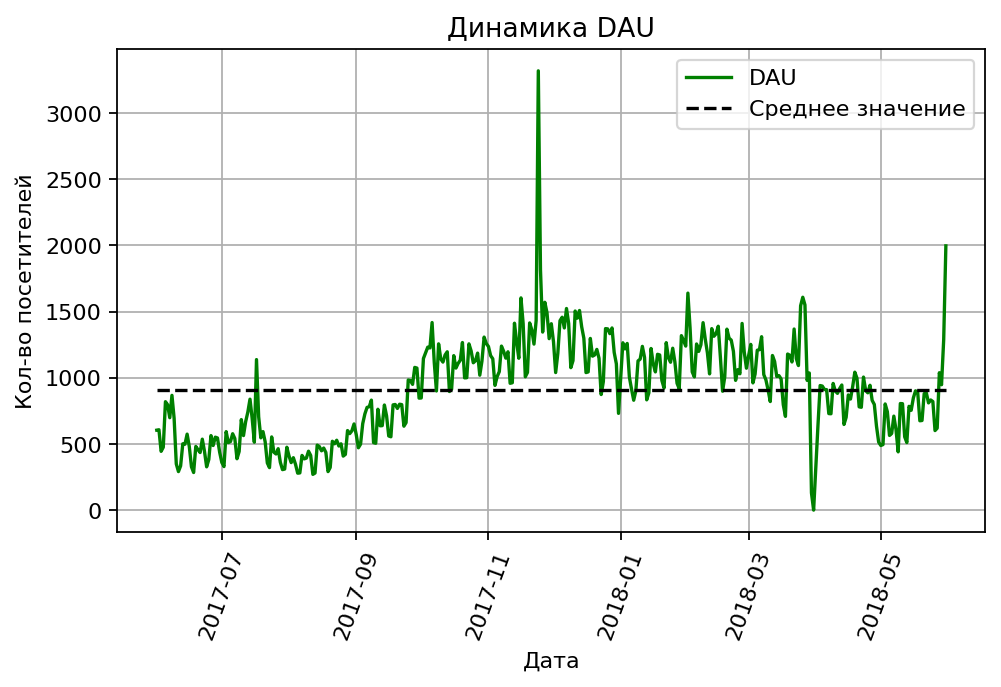

In [17]:
def draw_plot(x,y, labels={}, color='blue', size=(4,4), dpi=160, x_rot = 0, mean=False, legend=False):
    plt.figure(figsize=size, dpi=dpi)
    plt.title(labels['title'])
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.xticks(rotation=x_rot)
    plt.grid()
    plt.plot(x,y, color=color, label= labels['graph'],)
    if mean == True:
        y_mean = [np.mean(y)]*len(x)
        plt.plot(x,y_mean, label='Среднее значение', color='black', linestyle='--')
    if legend == True:
        plt.legend()
    plt.show()
    plt.close()
    
    
    
draw_plot(dau_metric['session_date'], dau_metric['uid'],
          labels={
              'xlabel':'Дата',
              'ylabel':'Кол-во посетителей',
              'title':'Динамика DAU',
              'graph':'DAU'
          },
          x_rot=70, size=(7,4), mean=True, legend=True, color='green')

На графике наблюдаем аномальное количество посетителей между 2017-11 и 2018-01.

In [18]:
print(dau_metric[dau_metric['uid'] == dau_metric['uid'].max()])

    session_date   uid
176   2017-11-24  3319


24 ноября 2017 года - день черной пятницы. Интересно, может, тогда на Яндекс.Афише было какое-либо промо по случаю черной пятницы?

Пока не будем изучать остальные аномальные моменты, но запомним их.

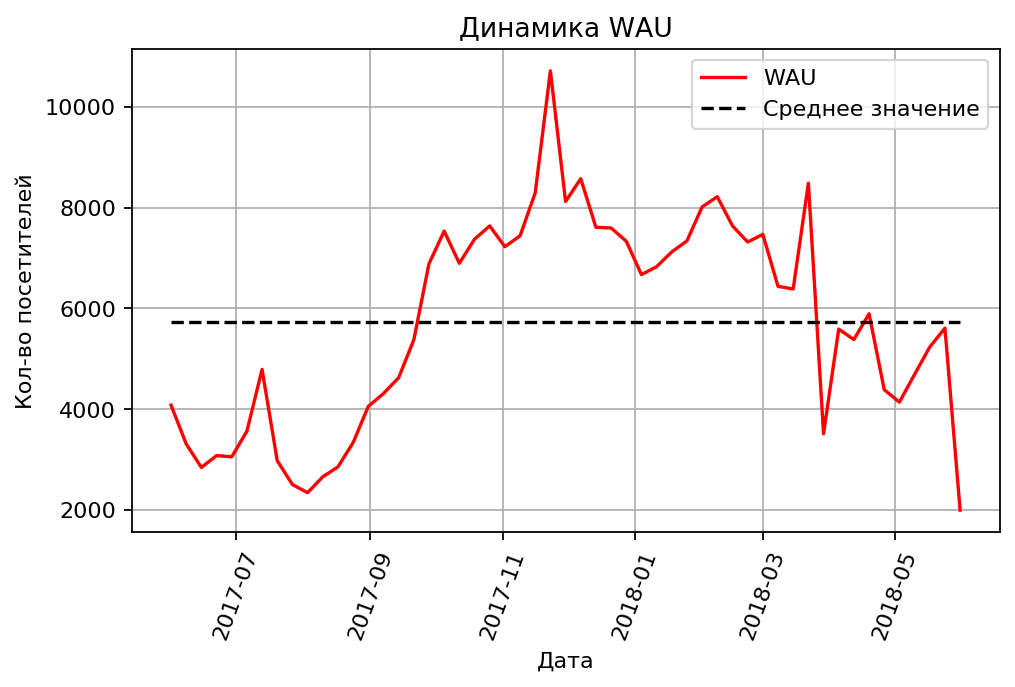

In [19]:
draw_plot(wau_metric['session_week'], wau_metric['uid'],
          labels={
              'xlabel':'Дата',
              'ylabel':'Кол-во посетителей',
              'title':'Динамика WAU',
              'graph':'WAU'
          },
          x_rot=70, size=(7,4), mean=True, color = 'red', legend=True)


По WAU наблюдается более плавный прирост посетителей к концу года, а после - плавное снижение. Минимальные показатели посетителей за месяц - летом, когда все в отпусках.

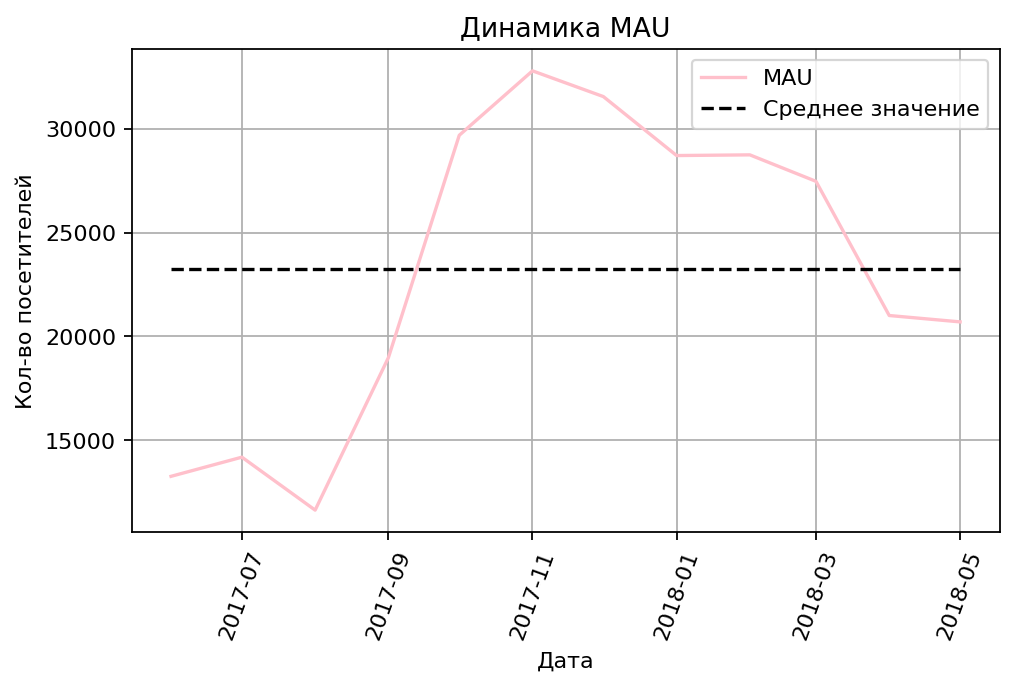

In [20]:
draw_plot(mau_metric['session_month'], mau_metric['uid'],
          labels={
              'xlabel':'Дата',
              'ylabel':'Кол-во посетителей',
              'title':'Динамика MAU',
              'graph':'MAU'
          },
          x_rot=70, size=(7,4), color='pink', mean=True, legend=True)

Динамика по MAU соответствует описанному в блоке с WAU - летом количество посетителей меньше.

Рассчитаем также Sticky factor за неделю и месяц.

In [21]:
print("Sticky factor за неделю равен {:.3f}".format(int(dau_metric.mean())/int(wau_metric.mean())))
print("Sticky factor за месяц равен {:.3f}".format(int(dau_metric.mean())/int(mau_metric.mean())))

Sticky factor за неделю равен 0.158
Sticky factor за месяц равен 0.039


### Количество пользователей в день/месяц

Теперь определим, сколько раз в день в среднем заходят пользователи на сайт Афиши.

In [22]:
user_per_day =visits.pivot_table(index='session_date', values='uid', aggfunc=['nunique', 'count']).reset_index(drop=False)
user_per_day.columns = ['session_date', 'nsess', 'unique_sessions', 'total_sessions']

# Метод pivot_table проводил рассчет для nunique для двух столбцов вместо одного, вручную удалил столбец
user_per_day = user_per_day.drop('nsess', axis=1)

user_per_day['user_ratio'] = user_per_day['total_sessions']/user_per_day['unique_sessions']

display(user_per_day)

print("Среднее количество посещений в день - {:.2f}".format(user_per_day['user_ratio'].mean()))

,session_date,unique_sessions,total_sessions,user_ratio
0,2017-06-01,605,664,1.097521
1,2017-06-02,608,658,1.082237
2,2017-06-03,445,477,1.071910
3,2017-06-04,476,510,1.071429
4,2017-06-05,820,893,1.089024
...,...,...,...,...
359,2018-05-27,620,672,1.083871
360,2018-05-28,1039,1156,1.112608
361,2018-05-29,948,1035,1.091772
362,2018-05-30,1289,1410,1.093871


Среднее количество посещений в день - 1.08


Теперь отобразим график с динамикой количества посещений за день.

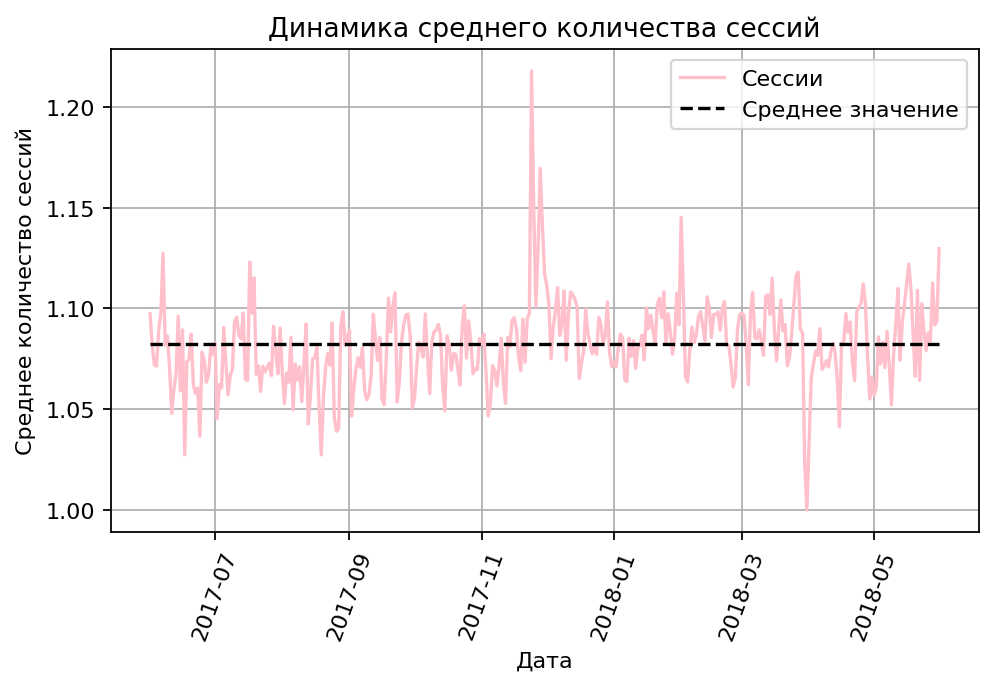

In [23]:
draw_plot(user_per_day['session_date'], user_per_day['user_ratio'],
          labels={
              'xlabel':'Дата',
              'ylabel':'Среднее количество сессий',
              'title':'Динамика среднего количества сессий',
              'graph':'Сессии'
          },
          x_rot=70, size=(7,4), color='pink', mean=True, legend=True)

Из графика видим, что количество посещений в день - величина волатильная, склонная к изменению. Попробуем рассчитать этот показатель по месяцам.

In [24]:
user_per_day['month'] = user_per_day['session_date'].astype('datetime64[M]')
user_per_month = (
    user_per_day
    .pivot_table(index='month', values=['unique_sessions', 'total_sessions'], aggfunc='sum')
    .reset_index(drop=False)
)

user_per_month['user_ratio'] = user_per_month['total_sessions']/user_per_month['unique_sessions']



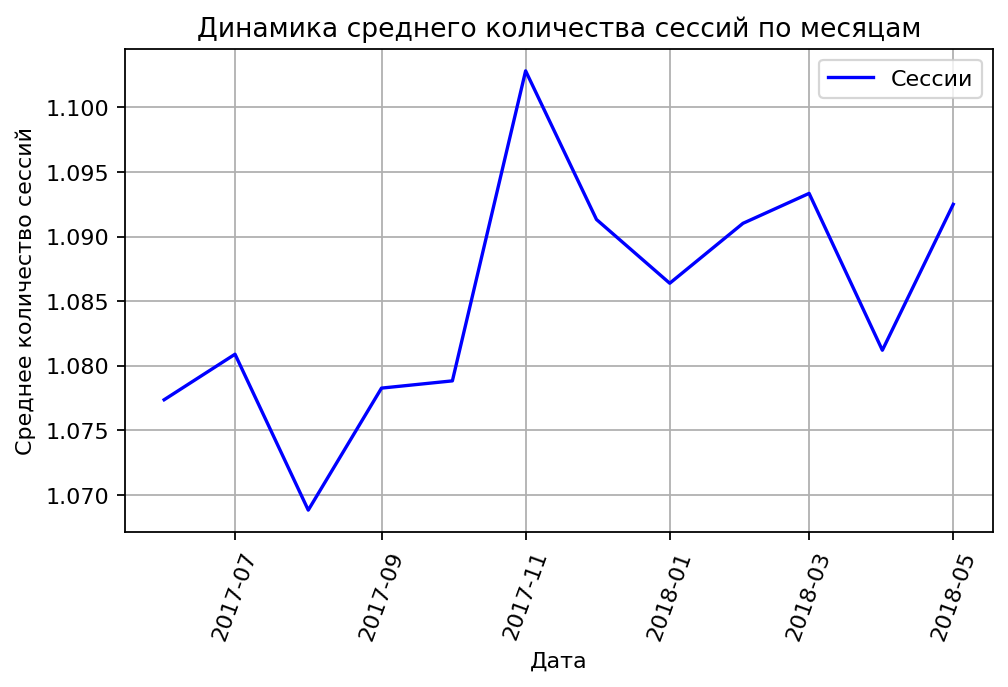

In [25]:
draw_plot(user_per_month['month'], user_per_month['user_ratio'],
          labels={
              'xlabel':'Дата',
              'ylabel':'Среднее количество сессий',
              'title':'Динамика среднего количества сессий по месяцам',
              'graph':'Сессии'
          },
          x_rot=70, size=(7,4), color='blue', mean=False, legend=True)

Количество пользователей, посещающих сайт Яндекс.Афиши более чем 1 раз за день, исторически растёт. 

### Длительность сессий

Теперь рассмотрим длительность сессий. Для начала попробуем поработать с интервалами в минуту. 

In [26]:
visits['session_lenght']= (visits['end_ts'] - visits['start_ts'])/np.timedelta64(1,'m')

display(visits)

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,session_lenght
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.000000
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.000000
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0.000000
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,24.000000
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,0.000000
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-27,2017-07-29,0.316667
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-25,2018-01-25,0.316667
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-01,2018-03-03,0.316667
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-02,2017-11-02,0.316667


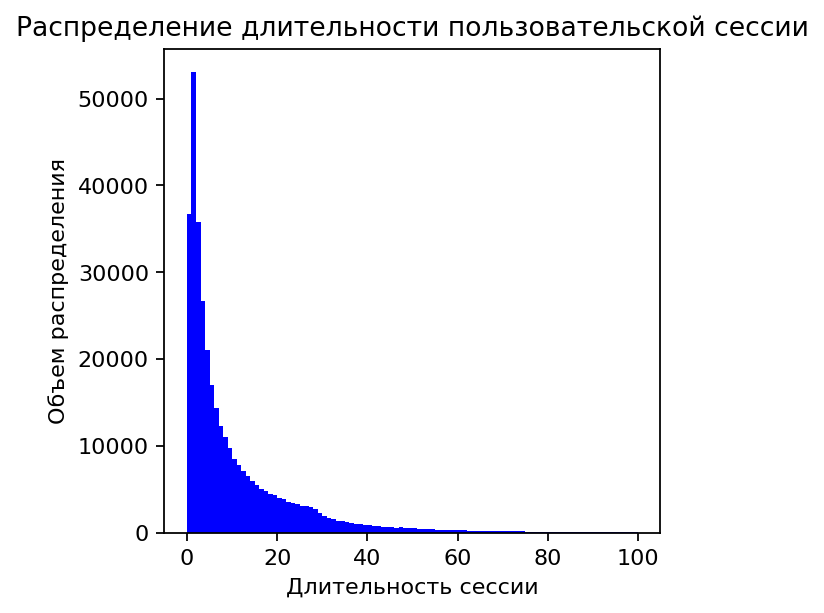

In [27]:
def draw_hist(x,bins= 10, labels={}, color='blue', size=(4,4), dpi=160, x_rot = 0, legend=False, x_range=(0, 1000)):
    plt.figure(figsize=size, dpi=dpi)
    plt.title(labels['title'])
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.xticks(rotation=x_rot)
    plt.hist(x,bins=bins, color=color,label=labels['graph'],range=x_range)
    plt.show()
    plt.close()
    
draw_hist(visits['session_lenght'], bins=100, 
         labels= {
             'title':'Распределение длительности пользовательской сессии',
             'xlabel':'Длительность сессии',
             'ylabel':'Объем распределения',
             'graph':'Сессии'
         }, x_range=(0,100))

Наиболее часто встречающееся значение в указанном распределении - 2 минуты. Посмотрим, какие данные мы можем извлечь из других источников.

In [28]:
visits['session_lenght'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_lenght, dtype: float64

In [29]:
iqr = int(visits['session_lenght'].quantile([0.75])) - int(visits['session_lenght'].quantile([0.25]))

print('Границы боксплота - от {} до {}'.format(int(visits['session_lenght'].quantile([0.25]))-iqr,
                                                int(visits['session_lenght'].quantile([0.75]))+iqr))

Границы боксплота - от -10 до 26


Получили дополнительные сведения по длительности сессии. Уже сейчас можно брать интервал от 0 до 26 минут как значение длительности обычной сессии. При этом обычное посещение длится 5 минут, что соответствует 50 процентилю.

Ввиду того, что распределение не является нормальным и имеет форму логарифмического, мы не можем брать среднее значение за величину обычной пользовательской сессии. 

В случае с такими средним значением является значение медианы. Таким образом,

In [30]:
print('Длительность пользовательской сессии в среднем составляет {} минут'.format(int(visits['session_lenght'].median())))

Длительность пользовательской сессии в среднем составляет 5 минут


Теперь оценим, как изменяется длительность сессии за период времени.

In [31]:
session_lenght_pivot = visits.groupby('session_date').agg({'session_lenght':'mean'}).reset_index()

display(session_lenght_pivot)

,session_date,session_lenght
0,2017-06-01,11.105346
1,2017-06-02,10.330674
2,2017-06-03,10.115968
3,2017-06-04,9.238497
4,2017-06-05,10.407503
...,...,...
359,2018-05-27,9.282738
360,2018-05-28,10.546987
361,2018-05-29,10.490467
362,2018-05-30,10.678463


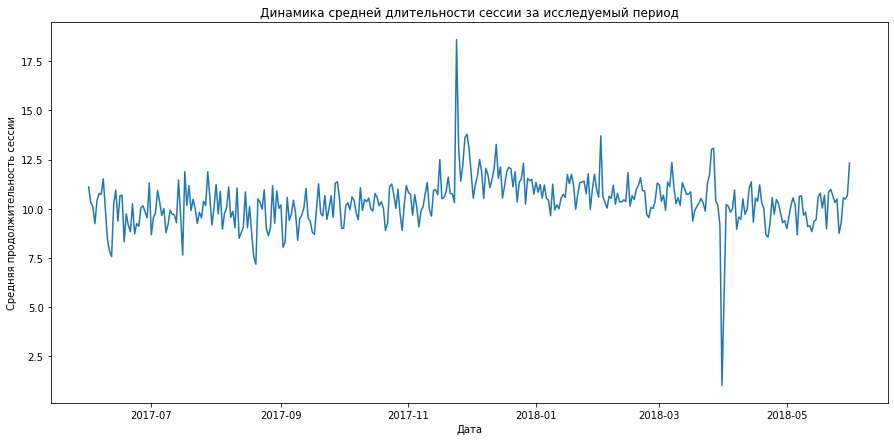

In [32]:
plt.figure(figsize=(15,7))
sns.lineplot(x='session_date', y='session_lenght', data=session_lenght_pivot)
plt.title('Динамика средней длительности сессии за исследуемый период')
plt.xlabel('Дата')
plt.ylabel('Средняя продолжительность сессии')
plt.show()

Динамика по средней продолжительности пользовательской сессии приблизительно совпадает с динамикой по DAU. Сравним аномальные значения.

In [33]:
dau_max = dau_metric['uid'].max()
dau_max_row = dau_metric[dau_metric['uid'] == dau_max]
dau_min = dau_metric['uid'].min()
dau_min_row = dau_metric[dau_metric['uid'] == dau_min]

session_lenght_min = session_lenght_pivot['session_lenght'].min()
session_lenght_min_row = session_lenght_pivot[session_lenght_pivot['session_lenght'] == session_lenght_min]

session_lenght_max = session_lenght_pivot['session_lenght'].max()
session_lenght_max_row = session_lenght_pivot[session_lenght_pivot['session_lenght'] == session_lenght_max]

In [34]:
print("Строки с максимальным и минимальным значением DAU:")
print(dau_max_row)
print(dau_min_row)
print("Строки с максимальным и минимальным значением средней продолжительности сессии :")
print(session_lenght_max_row)
print(session_lenght_min_row)

Строки с максимальным и минимальным значением DAU:
    session_date   uid
176   2017-11-24  3319
    session_date  uid
303   2018-03-31    1
Строки с максимальным и минимальным значением средней продолжительности сессии :
    session_date  session_lenght
176   2017-11-24       18.608408
    session_date  session_lenght
303   2018-03-31             1.0


Даты совпадают. Тогда попробуем посмотреть, есть ли корреляция между данными значениями.

In [35]:
session_lenght_pivot = session_lenght_pivot.merge(dau_metric, on='session_date') 

In [36]:
display(session_lenght_pivot.corr())

,session_lenght,uid
session_lenght,1.000000,0.679786
uid,0.679786,1.000000


Между количеством сессий и их длительностью есть корреляция.

### Retention rate

Теперь займемся расчетом Retention Rate. Для этого сформируем когорты на основании месяца первой сессии.

In [37]:
first_month = visits.groupby(['uid'])['start_ts'].min().astype('datetime64[M]')
first_month.name = 'first_session_month'

visits = visits.join(first_month, on='uid')

cohorts = visits

In [38]:
cohorts['cohort_lifetime'] = (cohorts['session_month'] - cohorts['first_session_month'])/np.timedelta64(1,'M')
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].apply(np.round)
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].astype('int')

cohorts = cohorts.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

display(cohorts)

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Теперь получим данные о размере когорт.

In [39]:
cohort_size = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
cohort_size = cohort_size.rename(columns={'uid':'cohort_size'})
display(cohort_size)

,first_session_month,cohort_size
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Объединим два датафрейма `cohort_size` и `cohorts`.

In [40]:
cohorts = cohorts.merge(cohort_size, on='first_session_month')
cohorts['retention'] = cohorts['uid']/ cohorts['cohort_size']

cohorts_life = cohorts[cohorts['cohort_lifetime'] != 0]
cohorts_life['first_session_month'] = cohorts_life['first_session_month'].dt.strftime('%Y-%m')


display(cohorts_life)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,first_session_month,cohort_lifetime,uid,cohort_size,retention
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557
5,2017-06,5,947,13259,0.071423
...,...,...,...,...,...
70,2018-02,2,565,22197,0.025454
71,2018-02,3,446,22197,0.020093
73,2018-03,1,861,20589,0.041818
74,2018-03,2,557,20589,0.027053


Построим сводную таблицу и тепловую карту.

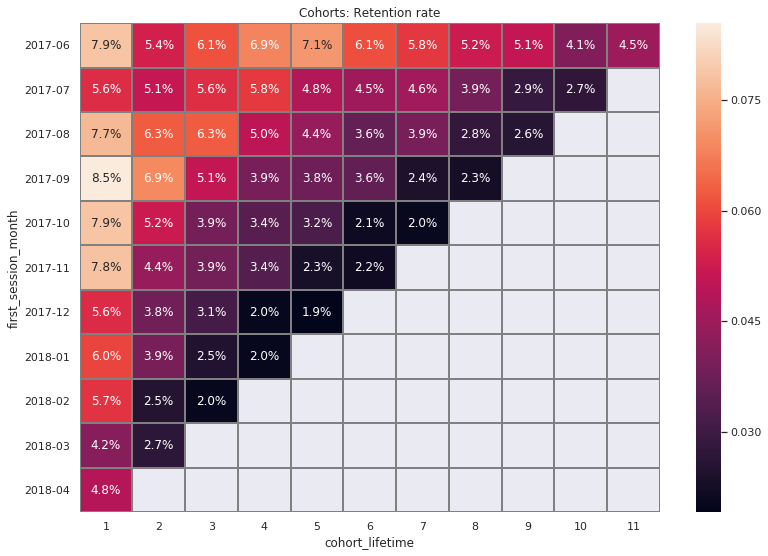

In [41]:
retention_pivot = cohorts_life.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Retention rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');


Изучив данные по RR, видим, что наибольший уровень возврата пользователей происходит во второй месяц после первого посещения сайта. Далее динамика склонна к снижению. Также по тепловой карте мы видим примерно одинаковые значения RR, расположенные по диагоналям, это связано с сезонностью.

Рассчитаем средний RR для всего периода и для второго периода отдельно.

In [42]:
display(retention_pivot.mean())

cohort_lifetime
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
11    0.044951
dtype: float64

In [43]:
print('Среднее значение Retention rate на второй месяц составило {:.3%}'.format(retention_pivot[1].mean()))

Среднее значение Retention rate на второй месяц составило 6.517%


Retention rate чаще всего не поднимается выше второго месяца. Исключение - период ноября и декабря, в ходе которого пользователи ищут, чем бы себя развлечь (из-за этого и трафик аномально растёт, и продолжительность сессии).

## Анализ метрик электронной коммерции

### Анализ цепочки событий "первая сессия – первая покупка"

Для начала изучим, сколько времени проходит с момента захода на сайт до совершения покупки.

In [44]:
print("Количество uid в датафрейме 'orders' - {}, количество уникальных uid в датафрейме 'orders' - {}"
     .format(orders['uid'].count(), orders['uid'].nunique()))

Количество uid в датафрейме 'orders' - 50415, количество уникальных uid в датафрейме 'orders' - 36523


На 50415 записей всего 36523 униальных uid. В рамках исследования мы будем изучать событие "первая покупка", поэтому перестроим наш датафрейм, оставив в нём только первые покупки.

In [45]:
first_buy = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()

Проведем поиск первой пользовательской сессии.

In [46]:
first_session = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()

In [47]:
visit_buy = first_session.merge(first_buy,on='uid')

In [48]:
display(visit_buy)

,uid,start_ts,buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


Получили датафрейм, содержащий только те uid, которые совершали покупку. Рассчитаем среднее время в днях, за которое пользователь совершает покупку.

In [49]:
visit_buy['order_time'] = ( visit_buy['buy_ts'] - visit_buy['start_ts'])/np.timedelta64(1,'D')

Построим распределение для того, чтобы понять, с каким распределением мы имеем дело.

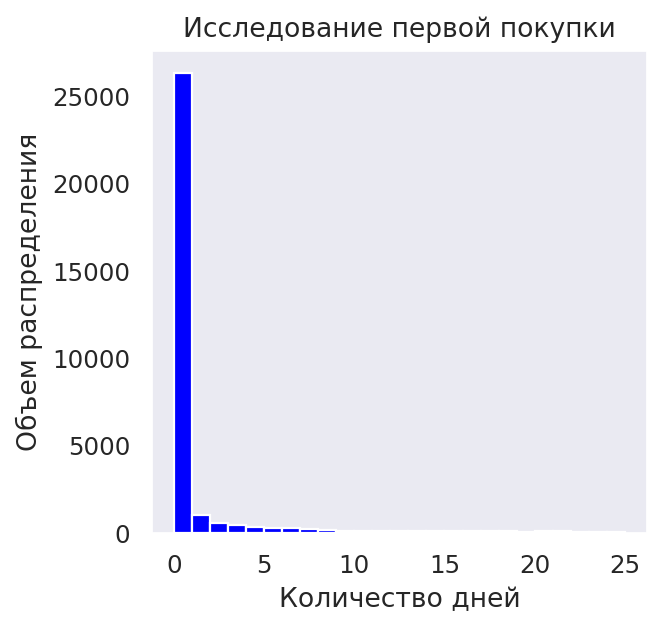

In [50]:
draw_hist(visit_buy['order_time'], bins=25, 
         labels= {
             'title':'Исследование первой покупки',
             'xlabel':'Количество дней',
             'ylabel':'Объем распределения',
             'graph':'Сессии'
         }, x_range=(0,25))

In [51]:
visit_buy['order_time'].describe()

count    36523.000000
mean        16.902900
std         47.072760
min          0.000000
25%          0.002778
50%          0.011111
75%          2.011806
max        363.294444
Name: order_time, dtype: float64

Подавляющее время покупок совершается в период первых двух дней. При этом аномальные значения по длительности покупки смещают среднее значение рассматриваемой величины. 

В связи с этим в качестве репрезентативного значения необходимо взять медиану. Таким образом,

In [52]:
print('Среднее время с момента первого посещения сайта до первой покупки составляет - {} дней'
      .format(int(visit_buy['order_time'].median())))

Среднее время с момента первого посещения сайта до первой покупки составляет - 0 дней


А это значит, что **покупка совершается первый же день посещения сайта**.

### Частота совершения покупок

**Среднее количество покупок без использования когортного анализа за весь период**

Для решения поставленной задачи сначала попробуем решить более простой кейс, получив основную информацию. А уже потом используем навыки исследования по когортам.

Для начала получим таблицу со всеми покупками по каждому пользователю из датафрейма `orders`.

In [53]:
count_orders = orders.groupby('uid').agg({'revenue':'count'}).reset_index()
display(count_orders)

,uid,revenue
0,313578113262317,1
1,1575281904278712,2
2,2429014661409475,1
3,2464366381792757,1
4,2551852515556206,2
...,...,...
36518,18445147675727495770,1
36519,18445407535914413204,3
36520,18445601152732270159,1
36521,18446156210226471712,1


Рассмотрим полученные данные подробнее.

In [54]:
count_orders['revenue'].describe()

count    36523.000000
mean         1.380363
std          3.454461
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
Name: revenue, dtype: float64

Исследование данных методом describe показывает, что в то время, когда на 75 перцентиль приходится значение количества покупок, равное 1, максимальное значение достигает 239 покупок. То есть, без построения распределения мы уже можем заявить, что имеем дело с логарифмическим распределением.


In [55]:
count_orders['revenue'].value_counts()

1      30231
2       4395
3       1086
4        375
5        147
       ...  
239        1
47         1
31         1
46         1
238        1
Name: revenue, Length: 62, dtype: int64

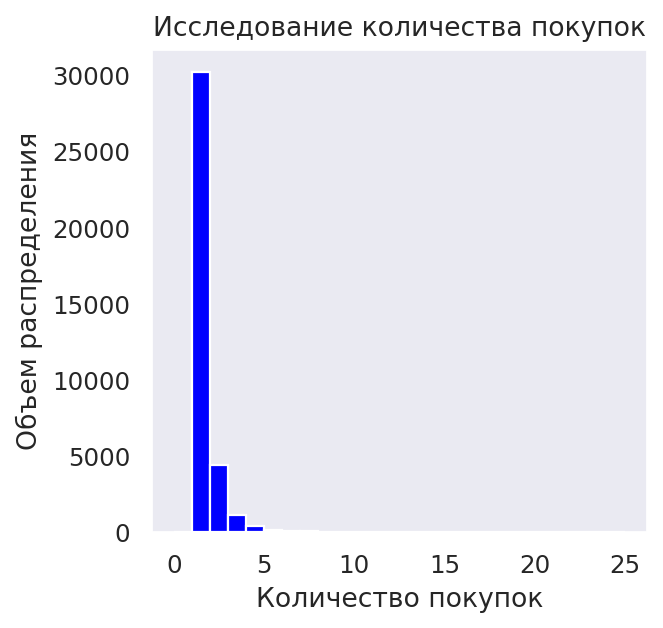

In [56]:
draw_hist(count_orders['revenue'], bins=25, 
         labels= {
             'title':'Исследование количества покупок',
             'xlabel':'Количество покупок',
             'ylabel':'Объем распределения',
             'graph':'Покупки'
         }, x_range=(0,25))

Без использования когортного анализа получается, что на одного пользователя в среднем приходится 1 покупка.

**Среднее количество покупок за 6 месяцев с использованием когортного анализа**

In [57]:
brief(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 11 columns):
device                 359400 non-null category
end_ts                 359400 non-null datetime64[ns]
source_id              359400 non-null int64
start_ts               359400 non-null datetime64[ns]
uid                    359400 non-null uint64
session_month          359400 non-null datetime64[ns]
session_week           359400 non-null datetime64[ns]
session_date           359400 non-null object
session_lenght         359400 non-null float64
first_session_month    359400 non-null datetime64[ns]
cohort_lifetime        359400 non-null int64
dtypes: category(1), datetime64[ns](5), float64(1), int64(2), object(1), uint64(1)
memory usage: 27.8+ MB


,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,session_lenght,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,0.0,2017-12-01,0


Количество дубликатов в датафрейме: 0


Сначала получим меся, в котором была совершен каждый заказ.

In [58]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Далее добавим в `orders` информацию для каждого `uid` с месяцем первой покупки.

In [59]:
orders = (
    orders.merge(
        orders
        .groupby('uid').agg({'order_month':'min'}).rename(columns={'order_month':'first_order_month'}).reset_index(),
        on='uid'
    )
)

Получим размеры когорт покупателей.

In [60]:
cohort_sizes = (orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Получим число поукпок для каждой когорты в разрезе месяца.

In [61]:
cohorts = (orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'count'}).reset_index())

Объединяем информацию по когортам и общему числу покупок.

In [62]:
report = cohort_sizes.merge(cohorts, on='first_order_month')

Расчитаем период жизни когорт.

In [63]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Получим среднее значение по когортам.

In [64]:
report['mean_orders'] = report['revenue'] / report['n_buyers']

In [65]:
report_pivot = report.pivot_table(index='first_order_month',
                                  columns='age',
                                  values='mean_orders',
                                  aggfunc='sum').cumsum(axis = 1)

display(report_pivot)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07-01,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08-01,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
print('В среднем на покупателя приходится около {:.2f} покупке'.format(report_pivot.mean()[5]))

В среднем на покупателя приходится около 1.43 покупке


### Расчет среднего чека

Теперь расчитаем средний чек в зависимости от месяца покупки.

При помощи датафрейма `orders` получим сводную таблицу, в которой индексом будет месяц покупки, а значения по количеству и сумме будут получены из столбца `revenue`.

In [67]:
mean_month = (
    orders.pivot_table(index='first_order_month', values='revenue', aggfunc=['count', 'sum'])
)

Теперь, когда у нас есть количество покупок и их сумма, мы можем получить средний чек в месяц. 

In [68]:
mean_month.columns = ['count_buy', 'sum_buy']

mean_month['mean_check'] = mean_month['sum_buy']/mean_month['count_buy']
mean_month = mean_month.reset_index()
display(mean_month)
print('Средний чек за весь период - {:.2f}'.format(mean_month['sum_buy'].sum()/mean_month['count_buy'].sum()))

,first_order_month,count_buy,sum_buy,mean_check
0,2017-06-01,4438,24031.69,5.414982
1,2017-07-01,2910,16127.92,5.542241
2,2017-08-01,2188,11606.26,5.304506
3,2017-09-01,3878,34676.32,8.941805
4,2017-10-01,6005,27603.45,4.596744
5,2017-11-01,5900,26098.99,4.423558
6,2017-12-01,5894,33485.74,5.681327
7,2018-01-01,4308,16663.13,3.867950
8,2018-02-01,4470,16750.50,3.747315
9,2018-03-01,4484,19273.41,4.298263


Средний чек за весь период - 5.00


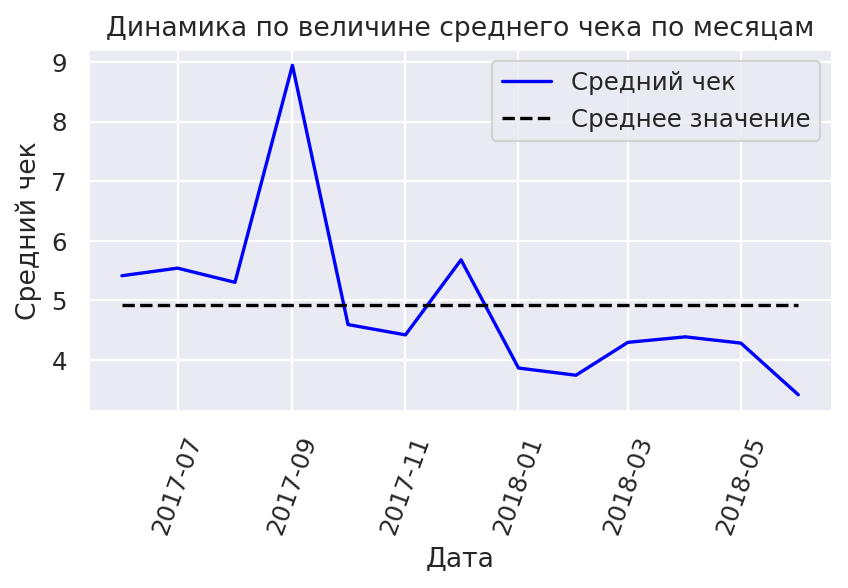

In [69]:
draw_plot(mean_month['first_order_month'],
          mean_month['mean_check'],
         labels={
              'xlabel':'Дата',
              'ylabel':'Средний чек',
              'title':'Динамика по величине среднего чека по месяцам',
              'graph':'Средний чек'
          }, mean=True, legend=True, x_rot=70, size=(6,3)
         )

### Расчет LTV

Теперь займёмся расчетом LTV для когорт. Сначала получим датафрейм, в котором будет отображена прибыль по месяцам для каждой когорты.

In [70]:
ltv = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue':'sum'})
    .reset_index()
)

Вновь добавим сведения о возрасте когорты.

In [71]:
ltv['age'] = ((
    ltv['order_month'] - ltv['first_order_month']
)/np.timedelta64(1,"M")
).apply(np.round).astype('int')

Создадим новый датафрейм, в котором объединим уже имеющуюся информацию по `cohort_sizes` и новую по `ltv`.

In [72]:
ltv_cohorts = cohort_sizes.merge(ltv, on='first_order_month')

Рассчитаем LTV для нового датафрейма.

In [73]:
ltv_cohorts['ltv'] = ltv_cohorts['revenue']/ltv_cohorts['n_buyers']

ltv_cohorts['first_order_month'] = ltv_cohorts['first_order_month'].dt.strftime('%Y-%m')

Рассмотрим полученные данные в форме сводной таблицы.

In [74]:
ltv_pivot = ltv_cohorts.pivot_table(index='first_order_month', columns='age', values='ltv').cumsum(axis=1)
ltv_pivot = ltv_pivot.fillna(0)

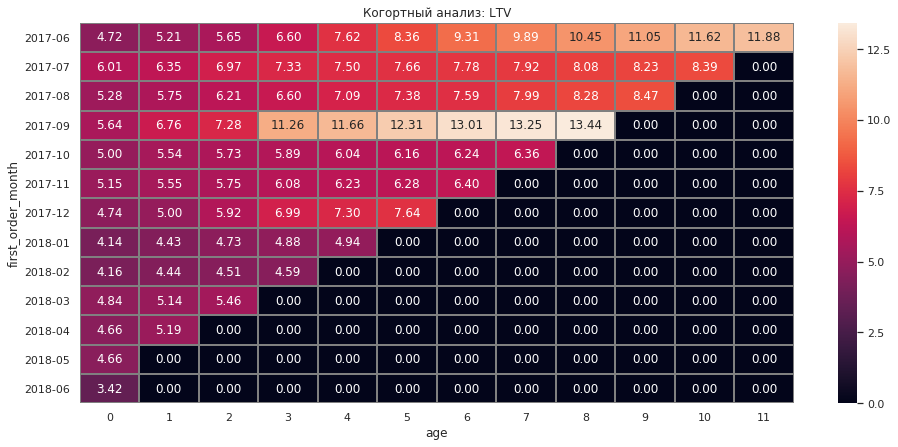

In [75]:
plt.figure(figsize=(16, 7))
plt.title('Когортный анализ: LTV')
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')


Получили данные по LTV для всех когорт покупателей. Теперь найдём среднее значение LTV на 6-ой месяц.

In [76]:
print('Среднее значение LTV за 6 месяцев составляет - {:.2f} y.e.'.format(ltv_pivot.mean()[5]))

Среднее значение LTV за 6 месяцев составляет - 4.29 y.e.


## Расчет маркетинговых метрик

### Рассчет расходов на маркетинг

Расчитаем общую сумму расходов на маркетинг

In [77]:
brief(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Количество дубликатов в датафрейме: 0


Столбец `source_id` не слишком информативен. Нужно будет попросить коллег дать словарь с этими id. Но что есть - то есть.

In [78]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()

display(costs_by_source)

print('Всего на маркетинг было потрачено - {:.2f} у.е.'.format(costs_by_source['costs'].sum()))

costs_period = (costs['dt'].max() - costs['dt'].min())/np.timedelta64(1, "D")
print('В среднем расходы на маркетинг составляют - {:.2f} у.е.'
     .format(costs_by_source['costs'].sum()/costs_period))

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Всего на маркетинг было потрачено - 329131.62 у.е.
В среднем расходы на маркетинг составляют - 904.21 у.е.


Посчитаем, получаем ли мы прибыль с проекта.

In [79]:
print("Выручка за вычетом маркетинговых расходов составляет - {:.2f} у.е."
      .format(orders['revenue'].sum() - costs_by_source['costs'].sum()))

Выручка за вычетом маркетинговых расходов составляет - -77074.42 у.е.


Получается, что сайт за данный период не принёс никакой прибыли, а работал себе в убыток.

Получили общий объем расходов на источник. Пока нам данный в таком разрезе не нужны, но вдруг ещё пригодится. 

А сейчас займёмся построением зависимости объемов расходов от конкретной даты.

In [80]:
costs_by_date = costs.pivot_table(index='dt', columns='source_id', values='costs').reset_index()

display(costs_by_date)

source_id,dt,1,2,3,4,5,9,10
0,2017-06-01,75.20,132.56,349.38,76.74,73.24,13.06,15.08
1,2017-06-02,62.25,132.38,314.22,59.21,123.82,18.13,11.18
2,2017-06-03,36.53,77.20,196.12,59.39,64.93,7.06,9.62
3,2017-06-04,55.00,79.08,389.87,161.97,52.77,4.65,17.82
4,2017-06-05,57.08,108.96,424.47,44.65,144.30,15.30,26.68
...,...,...,...,...,...,...,...,...
359,2018-05-27,30.89,113.35,254.90,28.04,84.66,11.11,9.92
360,2018-05-28,54.47,82.67,247.92,68.88,131.77,12.47,21.26
361,2018-05-29,61.13,105.75,347.59,103.84,138.33,16.83,11.32
362,2018-05-30,130.47,119.26,611.78,18.01,246.76,23.57,33.15


Теперь у нас есть датафрейм, в котором содержится подневная информация о расходах на каждый источник трафика. Отобразим динамику расходов по каждому источнику.

In [81]:
array_columns = costs_by_date.columns
array_columns = array_columns.drop('dt')

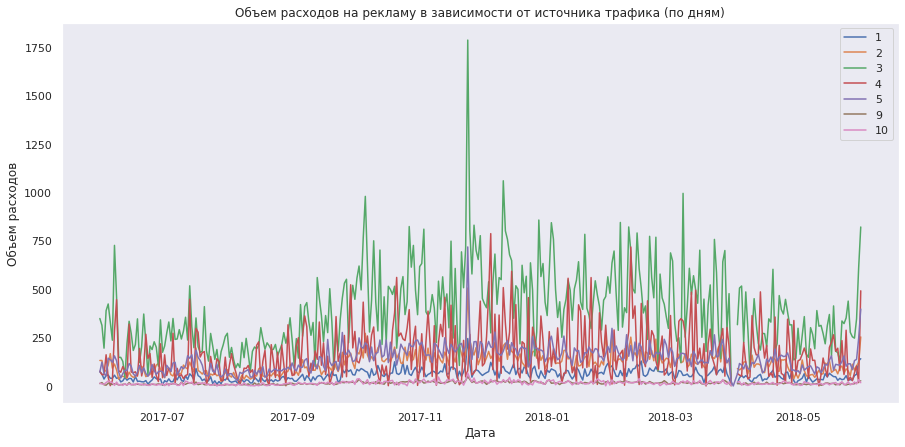

In [82]:
plt.figure(figsize=(15,7))
plt.title('Объем расходов на рекламу в зависимости от источника трафика (по дням)')
plt.xlabel('Дата')
plt.ylabel('Объем расходов')
for i in array_columns:
    plt.plot(costs_by_date['dt'], costs_by_date[i], label=i)
plt.legend()
plt.show()
plt.close()

Несмотря на перегруженность графика, отметим, что расходы на 3 источник трафика практически всегда больше остальных, тогда как на 10 и 9 источник трафика расходов практически нет.
Также отметим аномальные всплески по расходам на трафик. Они носят сезонный характер, что отмечалось ранее.

Теперь попробуем отразить динамику не по дням, а по неделям, сократив количество значений.

In [83]:
costs['order_week'] = costs['dt'].astype('datetime64[W]')

costs['order_month'] = costs['dt'].astype('datetime64[M]')

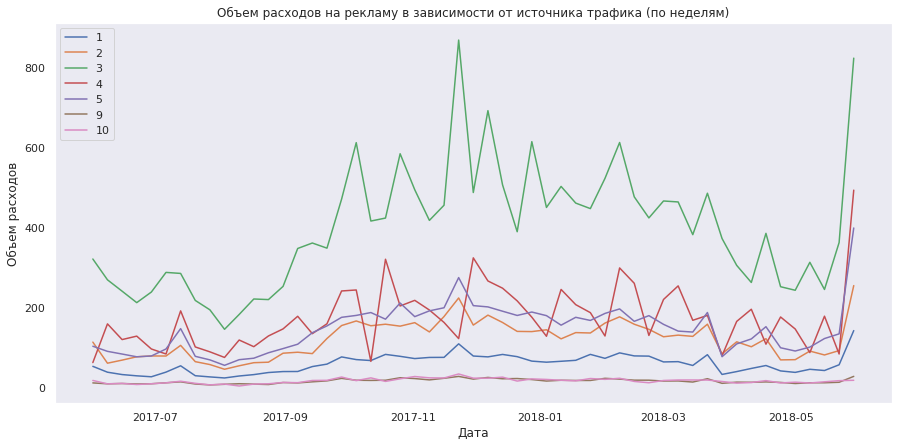

In [84]:
costs_by_week = costs.pivot_table(index='order_week', columns='source_id', values='costs').reset_index()

plt.figure(figsize=(15,7))
plt.title('Объем расходов на рекламу в зависимости от источника трафика (по неделям)')
plt.xlabel('Дата')
plt.ylabel('Объем расходов')
for i in array_columns:
    plt.plot(costs_by_week['order_week'], costs_by_week[i], label=i)
plt.legend()
plt.show()
plt.close()

График по неделям значительно более читабелен. 

Делаем следующие выводы по графику расходов:

1) Расходы на 3 источник трафика всегда опережают любые другие расходы.

2) Расходы на 9 и 10 источники трафика имеют наименьшее значение среди всех источников трафика.

3) Несмотря на сезонность рассматриваемой отрасли, не все источники трафика имеют склонность к приросту или падению в отдельный промежуток времени. К примеру, всплеск расходов с 2017-11 по 2018-01 никак не отразился на расходах на трафик по 4 источнику. Даже наоборот - там наблюдалось падение.

### Расчет CAC

Создадим датафрейм, в которой будет информация по первым источникам трафика для каждого пользователя, а также датафрейм, в котором будет информация по первой покупке пользователя.

In [85]:
first_session_source = (
    visits.sort_values(by = ['uid', 'start_ts'])
    .groupby('uid')
    .agg({
        'source_id':'first',
        'session_date':'first'
    })
)

first_order = (
    orders.sort_values(by = ['uid', 'buy_ts'])
    .groupby('uid')
    .agg({
        'buy_ts':'first'
    })
)
first_order = first_order.rename(columns={'buy_ts': 'order_date'})

first_order = first_order['order_date'].astype('datetime64[D]')

Объединим полученные таблицы в одну.

In [86]:
order_buy = first_session_source.merge(first_order, on='uid').reset_index()

order_buy['order_month'] = order_buy['order_date'].astype('datetime64[M]')
order_buy['session_month'] = order_buy['session_date'].astype('datetime64[M]')
display(order_buy)


,uid,source_id,session_date,order_date,order_month,session_month
0,313578113262317,2,2017-09-18,2018-01-03,2018-01-01,2017-09-01
1,1575281904278712,10,2017-06-03,2017-06-03,2017-06-01,2017-06-01
2,2429014661409475,3,2017-10-11,2017-10-11,2017-10-01,2017-10-01
3,2464366381792757,5,2018-01-27,2018-01-28,2018-01-01,2018-01-01
4,2551852515556206,5,2017-11-24,2017-11-24,2017-11-01,2017-11-01
...,...,...,...,...,...,...
36518,18445147675727495770,5,2017-08-20,2017-11-24,2017-11-01,2017-08-01
36519,18445407535914413204,3,2017-09-22,2017-09-22,2017-09-01,2017-09-01
36520,18445601152732270159,2,2017-08-07,2018-03-26,2018-03-01,2017-08-01
36521,18446156210226471712,3,2017-11-07,2018-02-18,2018-02-01,2017-11-01


Подготовим таблицу, в которой будет указано общее число покупок на день в разрезе `source_id`.

In [87]:
orders_num = order_buy.groupby(['session_date', 'source_id']).agg({'uid':'count'}).reset_index()
orders_num = orders_num.rename(columns={'session_date':'date', 'uid':'n_buyers'})

orders_num['date'] = orders_num['date'].astype('datetime64[D]')
orders_num['month'] = orders_num['date'].astype('datetime64[M]')

In [88]:
orders_num = orders_num.groupby(['month', 'source_id']).agg({'n_buyers':'sum'}).reset_index()

Расчитаем расходы по месяцам в разрезе `source_id`.

In [89]:
costs_by_month = costs.groupby(['order_month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_by_month = costs_by_month.rename(columns={'order_month':'month', 'uid':'n_buyers'})

Теперь объединим две таблицы для того, чтобы получить сведения по ежемесячным расходам и количеству покупателей в разрезе `source_id`.

In [90]:
report = orders_num.merge(costs_by_month, on=['month','source_id'], how='inner')

In [91]:
display(report)

,month,source_id,n_buyers,costs
0,2017-06-01,1,240,1125.61
1,2017-06-01,2,374,2427.38
2,2017-06-01,3,886,7731.65
3,2017-06-01,4,647,3514.80
4,2017-06-01,5,509,2616.12
...,...,...,...,...
79,2018-05-01,3,624,9411.42
80,2018-05-01,4,611,4214.21
81,2018-05-01,5,406,3669.56
82,2018-05-01,9,30,362.17


Рассчитаем метрику CAC.

In [92]:
report['cac'] = report['costs']/report['n_buyers']

Теперь рассмотрим на указанные значения в разресе `source_id`.

In [93]:
report_groups = report.groupby('source_id').agg({'n_buyers':'sum', 'costs':'sum'})

In [94]:
report_groups['cac'] = report_groups['costs']/report_groups['n_buyers']

In [95]:
display(report_groups)

,n_buyers,costs,cac
source_id,,,
1,2899,20833.27,7.186364
2,3506,42806.04,12.209367
3,10473,141321.63,13.493901
4,10296,61073.60,5.931779
5,6931,51757.10,7.467479
9,1088,5517.49,5.071222
10,1329,5822.49,4.381106


Отобразим графически полученные сведения по CAC в разрезе источников трафика.

In [96]:
report_pivot = report.pivot_table(index='month', columns='source_id', values='cac').reset_index()

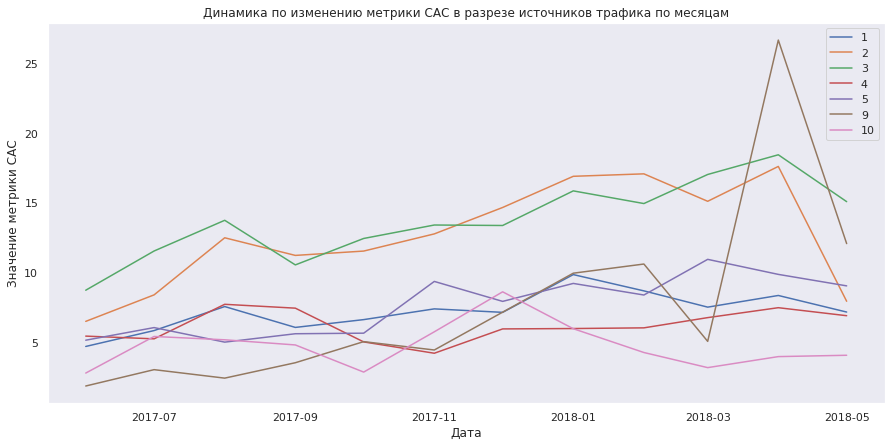

In [97]:
plt.figure(figsize=(15,7))
plt.title('Динамика по изменению метрики CAC в разрезе источников трафика по месяцам')
plt.xlabel('Дата')
plt.ylabel('Значение метрики CAC')
for i in array_columns:
    plt.plot(report_pivot['month'], report_pivot[i], label=i)
plt.legend()
plt.show()
plt.close()

Теперь построим график CAC для одного значения.

In [98]:
cac_monthly = report.groupby('month').agg({'n_buyers':'sum', 'costs':'sum'}).reset_index()
cac_monthly['cac'] = cac_monthly['costs']/cac_monthly['n_buyers']

In [99]:
print('Среднее значение метрики CAC равно {:.2f} у.е.'.format(cac_monthly['cac'].mean()))

Среднее значение метрики CAC равно 9.11 у.е.


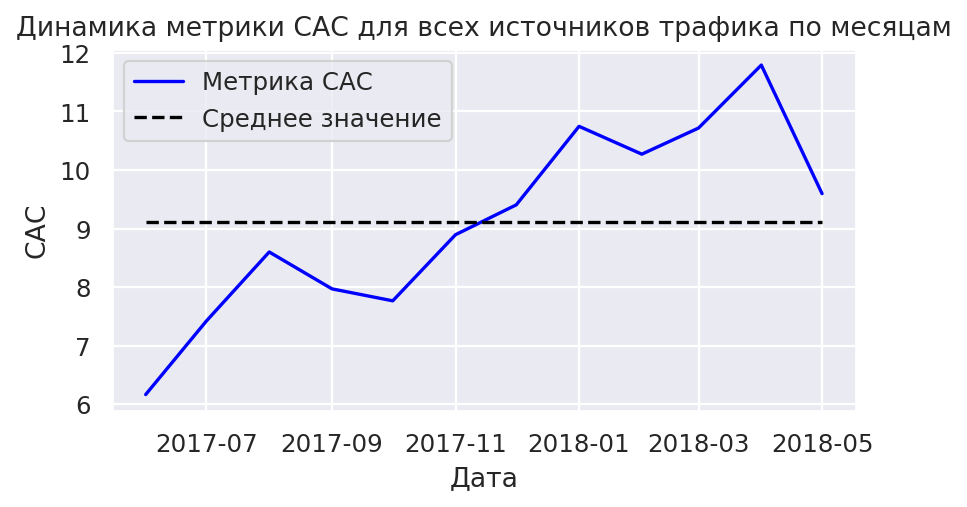

In [100]:
draw_plot(cac_monthly['month'],
          cac_monthly['cac'],
         labels={
              'xlabel':'Дата',
              'ylabel':'CAC',
              'title':'Динамика метрики CAC для всех источников трафика по месяцам',
              'graph':'Метрика CAC'
          }, mean=True, legend=True, x_rot=0, size=(6,3)
         )

### Расчет ROMI

Для расчета ROMI нам нужно получить информацию по LTV в разрезе по источникам финансирования. Поэтому сначала получим сводную таблицу с этими данными.

Для этого нам необходимо получить информацию по источнику, из которого впервые пользователь попал на Афишу. 

После - создадим функцию по поиску значения ROMI, где входным значением будет номер источника.


In [101]:
first_session_source = (
    visits.sort_values(by = ['uid', 'start_ts'])
    .groupby('uid')
    .agg({
        'source_id':'first',
        'session_month':'first'
    })
)

def ROMI_calc(source):
    margin_rate = 1.0
    
    source_users = first_session_source.query('source_id == @source').index.values
    source_orders = orders.query('uid in @source_users')

    cohort_sizes = (source_orders.groupby(['first_order_month'])).agg({'uid':'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month',  'n_buyers']
    cohorts = (source_orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'})).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report ['order_month'] - report['first_order_month'])/ np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp']/report['n_buyers']

    output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    output = output.cumsum(axis=1).fillna(0)

    source_costs = costs.query('source_id == @source')
    source_costs = source_costs.groupby('order_month').agg({'costs':'sum'})
    source_costs = source_costs.join(cohort_sizes.set_index('first_order_month'))
    source_costs['cac'] = source_costs['costs']/source_costs['n_buyers']
    
    output = output.div(source_costs['cac'], axis=0)
    
    return output


В рамках исследования посмотрим, по каким источникам трафика осуществлялись заказы

In [102]:
def calc_orders():
    for i in range (1, 10):
        source_users = first_session_source.query('source_id == @i').index.values
        source_orders = orders.query('uid in @source_users')
        print('Для источника {} всего было сделано - {} заказов'.format(i, source_orders['revenue'].count()))

        
calc_orders()

Для источника 1 всего было сделано - 5223 заказов
Для источника 2 всего было сделано - 6392 заказов
Для источника 3 всего было сделано - 13289 заказов
Для источника 4 всего было сделано - 12895 заказов
Для источника 5 всего было сделано - 9406 заказов
Для источника 6 всего было сделано - 0 заказов
Для источника 7 всего было сделано - 1 заказов
Для источника 8 всего было сделано - 0 заказов
Для источника 9 всего было сделано - 1647 заказов


Далее не будем учитывать 6, 7 и 8 источники, по ним заказов совсем нет.

Для упрощения отображения тепловых карт создадим функцию по быстрому отображению.

In [103]:
def heatmap(x, y):
    sns.set(style='white')
    plt.figure(figsize=(20, 9))
    plt.title('Расчет показателя ROMI с накоплением для источника - {}'.format(y))
    sns.heatmap(x, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Отобразим первые 5 тепловых карт.

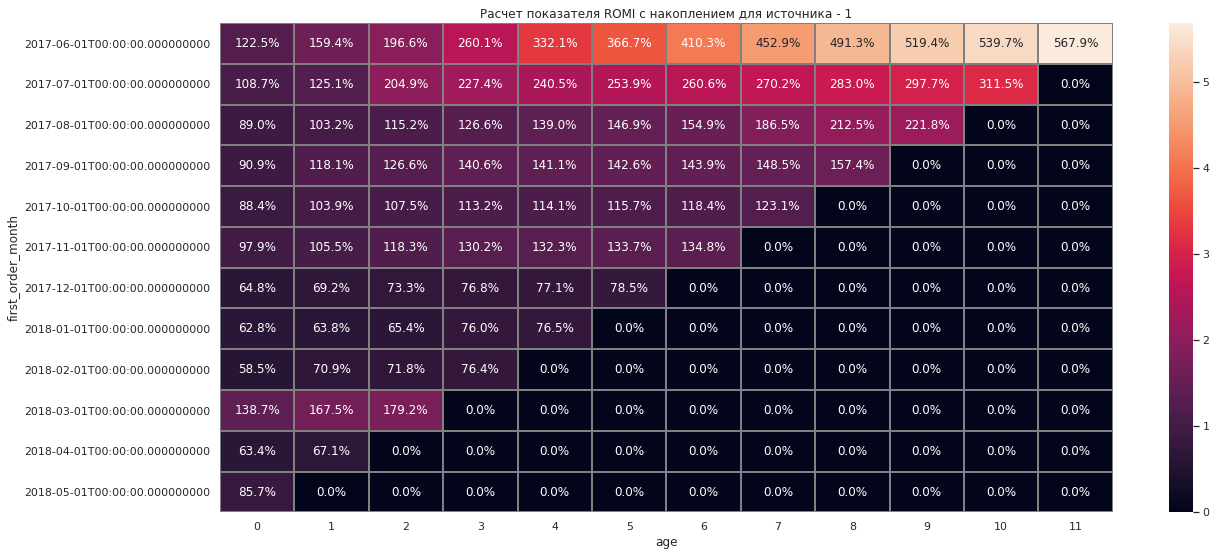

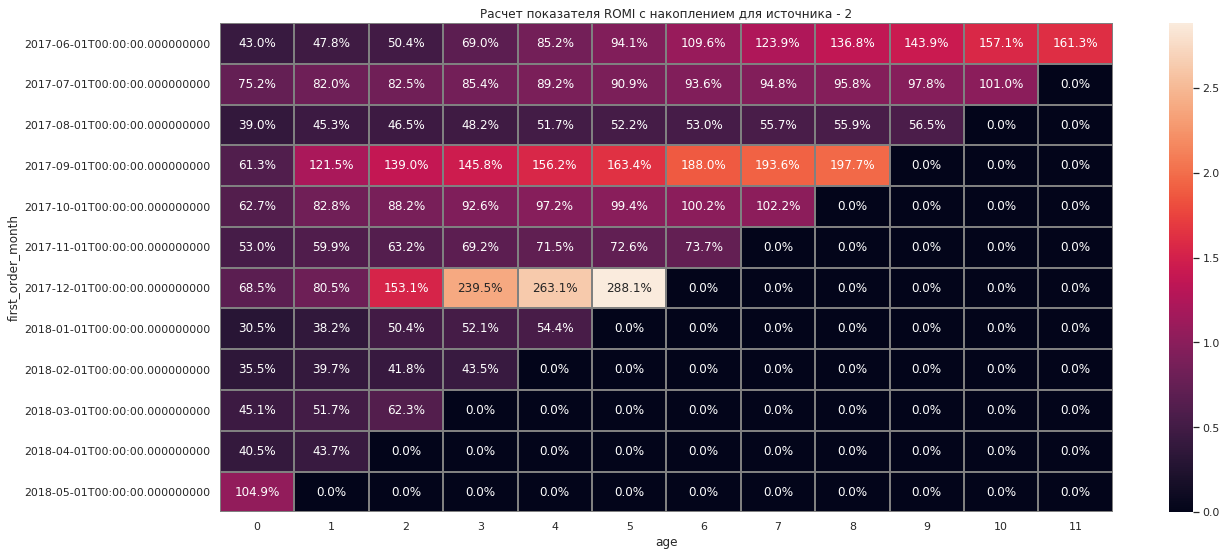

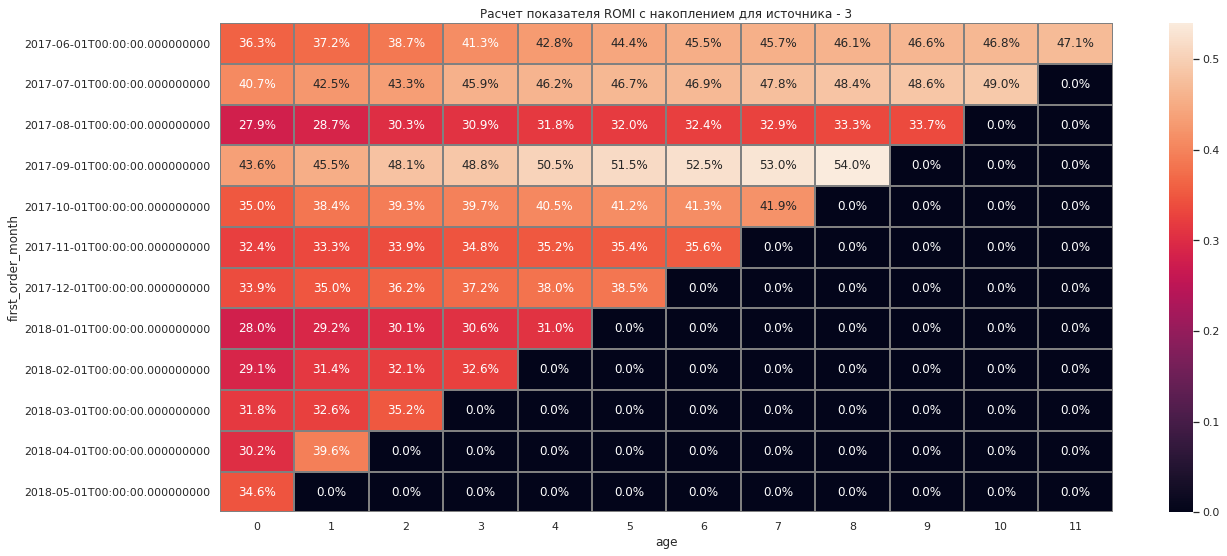

In [104]:
heatmap(ROMI_calc(1), 1)
heatmap(ROMI_calc(2), 2)
heatmap(ROMI_calc(3), 3)

Прокомментируем полученные тепловые карты:

1 источник трафика:
1. На 6 месяц вложения рекламу по когортам начинают окупаться. 
2. Первый месяц покупки окупает примерно половину расходов на маркектинг

2 источник трафика:
1. Однозначный период окупаемости назвать нельзя, когорты по-разному окупаются. 

3 источник трафика не окупается ни по одной когорте.

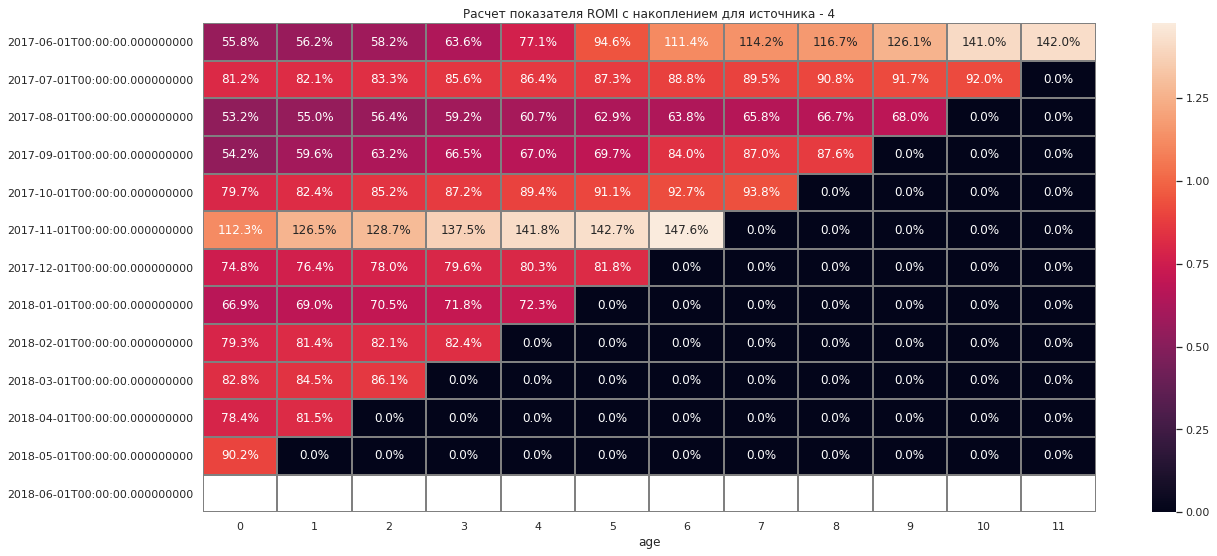

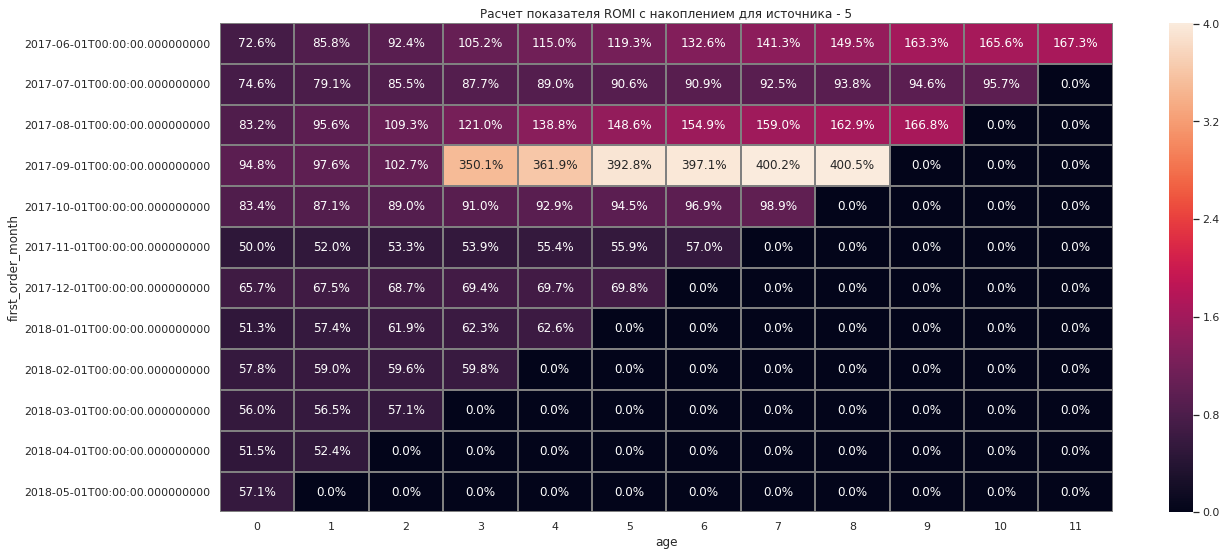

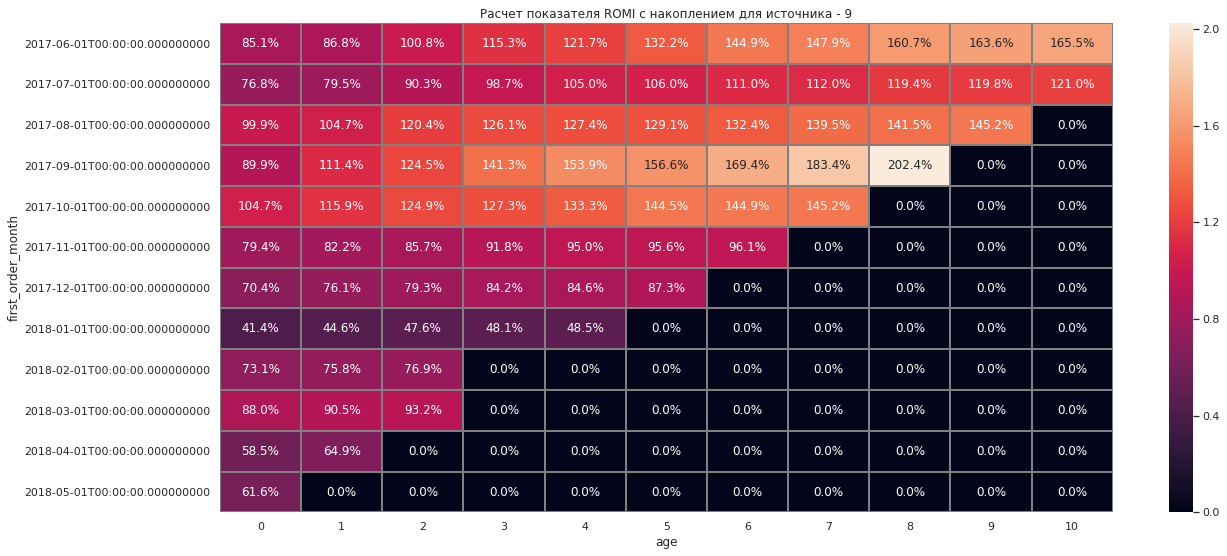

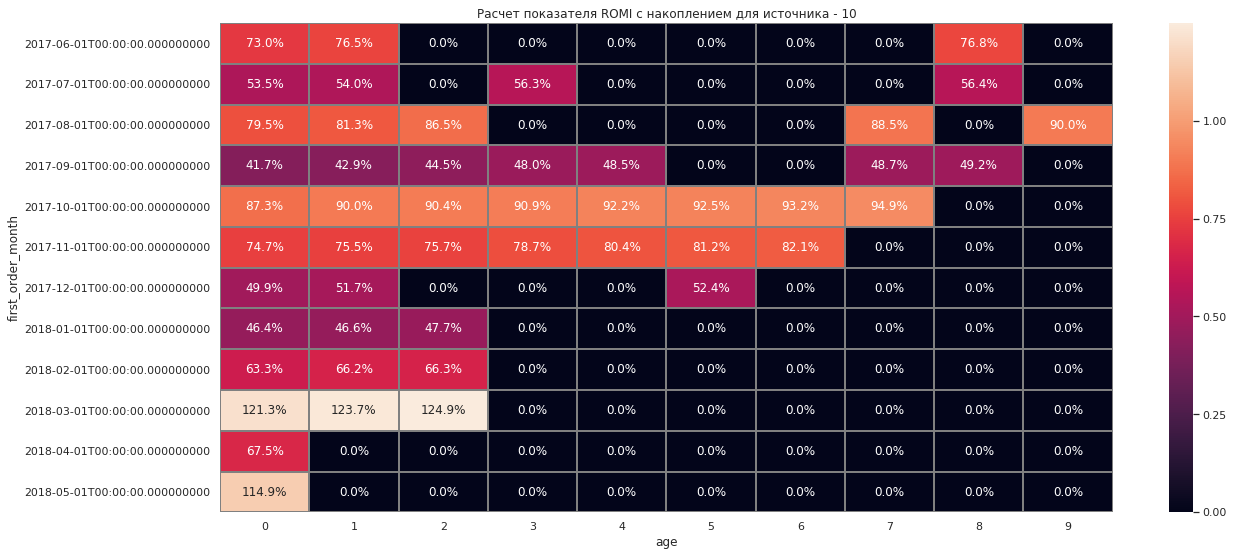

In [105]:
heatmap(ROMI_calc(4), 4)
heatmap(ROMI_calc(5), 5)
heatmap(ROMI_calc(9), 9)
heatmap(ROMI_calc(10), 10)

4 источник трафика слабо окупается, но в каждой когорте он близок к отметке 100%.

5 источник трафика окупается на 8 месяц.

9 источник трафика имеет самых активных покупателей из ранних когорт, по которым показатель ROMI превышает 200% на 9-ый месяц.

10 источник трафикеа не окупается.

## Выводы и рекомендации

### Анализ источников трафика, рекомендации маркетологам

**Анализ источников трафика**

По полученному анализу источнков трафика сделаем выводы и дадим рекомендации:

- Расходы на третий источник трафика не окупаются даже спустя 12 месяцев "жизни" представителей когорт. Да, это второй по величине источник покупок, но какой в нём смысл, если он не несёт прибыли? По данному трафику нужно либо постараться сократить объемы расходов, либо изменить качественный показатели вида привлечений. 

По большому счёту третий источник трафика необходимо изучать отдельно: взять точную информацию по маркетинговой части(что за баннеры, реклама, способы привлечения), проанализировать точнее пользователей, которые переходят по ней (их увлечения, гендер, возраст) и подобрать такие промо, которые бы привлекли их внимание.

- Четвертый источник трафика при гораздо меньших расходах, чем третий, генерирует куда больше заказов. Да, по нему ROMI не однозначна. По этому источнику лучше всего попробовать увеличить бюджет.


**Рекомендации маркетологам**

Основываясь на данных по ROMI рекомендуем коллегам:

- Отказаться от вложений в 3 и 10 источники трафика. 10 источник не привлекает продаж месяцами. По итогу будет освобождено более 140.000 у.е. для вложений в другие источники трафика.

- Сосредоточиться на рекмламе для 9 источника трафика как самого перспективного.

### Выводы по маркетинговым метрикам.

Отметим тезисно выводы по маркетинговым исследованиям:

Всего на маркетинг было потрачено - 329131.62 у.е., в среднем расходы на маркетинг составляют - 904.21 у.е. Наибольшая статья расходов на маркетинг - обеспечение притока трафика по `source_id = 3`, но этот трафик не окупается. 

С другой стороны, метрика `CAC` в ходе исследования имеет тенденцию к росту, что говорит о понижении эффективности маркетинга. При этом напомним себе, что исследование затронуло 1 сезон, а исследуемый сайт зависит от сезона. Поэтому однозначно сказать, что эффективность маркетинга снижается - нельзя.



### Выводы по продуктовым метрикам.

Основные показатели, которые были рассмотрены: 

- Среднее значение DAU - 907
- Среднее значение WAU - 5724
- Среднее значение MAU - 23228
- Среднее количество посещений в день - 1.08
- Медиана по длительности сессии - 5 минут.

Среднее количество сессий месяц за рассматриваемый промежуток времени показало положительную динамику. 

Количество посещений лежит в диапазоне от 0 до 26 минут, а самая частая длительность сессии - 5 минут.

Важно отметить, что исследование продуктовых метрик за данный период времени, к сожалению, не даст полной картины по данным видам метрики. 

Всё дело в сезонности - если бы промежуток времени, который был рассмотрен в данном исследовании, был примерно с августа 2018 по июль 2019, мы бы увидели отрицательную динамику и поразились бедовой ситуации. 



### Выводы по метрикам электронной коммерции

Опишем следующие результаты:

За 6 месяцев всего  1 пользователь из 4-х совершает какую-либо покупку. От события "первая сессия" до события "первая покупка" в среднем проходит 16.9 дня. При этом средний чек составляет 5 у.е.

Средний LTV для рассматриваемых когорт составил 1.3 y.e., по динамике изменения LTV для рассмотренных когорт нельзя сделать однозначных выводов: когорта пришедших и купивших в период черной пятницы более склонна к трате денег в период "черной пятницы", чем августовская или январская когорта. 


### Выводы по корогтному анализу

Когортный анализ показал, что представители самой ранней когорты `2017-06-01` и более склонны тратить деньги, и по всем способом перехода на сайт более остальных рентабельны. 

С другой стороны, когорты, пришедшие в впраздники или в период скидок, менее рентабельны по ROMI, а для последних трёх по дате первой сессии когорт делать выводы преждевременно. 

Поэтому необходимо сосредоточиться на первых 4-х когортах: они пришли на сайт в спокойное время, их никто не торопил и не вынуждал в июне или августе что-то покупать. Скорее всего, это именно те пользователи, которым интересен сам ресурс и его услуги.
